# A Quantum-Enhanced LSTM Layer

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import torch_geometric as pyg
from torch_geometric.datasets import QM9

In [3]:
import scipy

In [4]:
import warnings

In [5]:
import sys
sys.path.insert(1, 'netgan_pytorch/netgan')
from utils import *

Here we process some data

In [6]:
dataset = QM9('', transform=None, pre_transform=None, pre_filter=None)

In [7]:
sym_to_ix = {"C" : 6, "H" : 1, "N" : 7, "O": 8}
ix_to_tag = {i : sym for sym, i in sym_to_ix.items()}

In [8]:
import networkx as nx
from torch_geometric.utils import to_networkx

The function below tokenizes the sentence and matches the label to each word.

In [9]:
methane = dataset[220]

In [10]:
graph = to_networkx(methane)

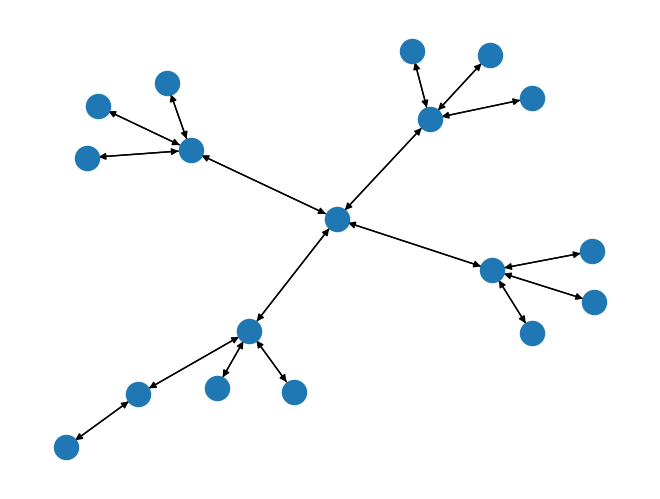

In [11]:
nx.draw(graph, label=True)

In [12]:
ch4 = nx.to_numpy_array(graph)

In [13]:
ch4[ch4!=0] = 1.0
graph_nx = nx.from_numpy_array(ch4)
graph_sparse = scipy.sparse.csr_matrix(ch4)
n_edges = ch4.sum()

In [14]:
graph_sparse

<18x18 sparse matrix of type '<class 'numpy.float64'>'
	with 34 stored elements in Compressed Sparse Row format>

In [15]:
print(f"This graph has {n_edges} edges!")

This graph has 34.0 edges!


In [16]:
tr, vo, vz, ts, tz = train_val_test_split_adjacency(graph_sparse, connected=True)

This graph is connected
idx_ones looks like [ 1  6  8  9 13  4  2 14 10  7 16 11  3  0  5 15 12]
s_train is equal to 11
test_ones looks like [[ 3 13]
 [ 1  0]
 [ 0  6]
 [ 2  1]
 [16  4]
 [ 3 14]]
N_test is 6.
test_zeros looks like [[ 1  6]
 [ 7 14]
 [13  8]
 [ 9 16]
 [ 5 15]
 [15  0]] with length 6.


/Users/May/Downloads/netgan_pytorch/netgan/utils.py:167: UserWarning: Graph appears to be undirected. Did you forgot to set undirected=True?
  warnings.warn('Graph appears to be undirected. Did you forgot to set undirected=True?')


In [17]:
train_graph = scipy.sparse.coo_matrix((np.ones(len(tr)), (tr[:, 0], tr[:, 1]))).tocsr()

In [18]:
walker = RandomWalker(train_graph, 18, p=1, q=1, batch_size=162)

In [19]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.cell = nn.Linear(input_size+hidden_size, 4 * hidden_size, bias=True)
        torch.nn.init.xavier_uniform_(self.cell.weight)
        torch.nn.init.zeros_(self.cell.bias)

    def forward(self, x, hidden):
        hx, cx = hidden
        gates = torch.cat((x, hx), dim=1)
        gates = self.cell(gates)

        ingate, cellgate, forgetgate, outgate = gates.chunk(4, 1)

        ingate = torch.sigmoid(ingate)
        forgetgate = torch.sigmoid(torch.add(forgetgate, 1.0))
        cellgate = torch.tanh(cellgate)
        outgate = torch.sigmoid(outgate)
        cy = torch.mul(cx, forgetgate) + torch.mul(ingate, cellgate)
        hy = torch.mul(outgate, torch.tanh(cy))
        return (hy, cy)

In [20]:
class Discriminator(nn.Module):
    def __init__(self, H_inputs, H, N, rw_len):
        '''
            H_inputs: input dimension
            H:        hidden dimension
            N:        number of nodes (needed for the up and down projection)
            rw_len:   number of LSTM cells
        '''
        super(Discriminator, self).__init__()
        self.W_down = nn.Linear(N, H_inputs, bias=False).type(torch.float64)
        torch.nn.init.xavier_uniform_(self.W_down.weight)
        self.lstmcell = LSTMCell(H_inputs, H).type(torch.float64)
        self.lin_out = nn.Linear(H, 1, bias=True).type(torch.float64)
        torch.nn.init.xavier_uniform_(self.lin_out.weight)
        torch.nn.init.zeros_(self.lin_out.bias)
        self.H = H
        self.N = N
        self.rw_len = rw_len
        self.H_inputs = H_inputs

    def forward(self, x):
        x = x.view(-1, self.N)
        xa = self.W_down(x)
        xa = xa.view(-1, self.rw_len, self.H_inputs)
        hc = self.init_hidden(xa.size(0))
        for i in range(self.rw_len):
            hc = self.lstmcell(xa[:, i, :], hc)
        out = hc[0]
        pred = self.lin_out(out)
        return pred

    def init_inputs(self, num_samples):
        weight = next(self.parameters()).data
        return weight.new(num_samples, self.H_inputs).zero_().type(torch.float64)

    def init_hidden(self, num_samples):
        weight = next(self.parameters()).data
        return (weight.new(num_samples, self.H).zero_().contiguous().type(torch.float64), weight.new(num_samples, self.H).zero_().contiguous().type(torch.float64))

In [21]:
import pennylane as qml
from math import *


class QLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, n_qubits, n_qlayers=1, backend="default.qubit"):
        super(QLSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.n_qubits = n_qubits
        self.n_qlayers = n_qlayers
        self.backend = backend  # "default.qubit", "qiskit.basicaer", "qiskit.ibm"

        self.wires_forget = [f"wire_forget_{i}" for i in range(self.n_qubits)]
        self.wires_input = [f"wire_input_{i}" for i in range(self.n_qubits)]
        self.wires_update = [f"wire_update_{i}" for i in range(self.n_qubits)]
        self.wires_output = [f"wire_output_{i}" for i in range(self.n_qubits)]

        self.dev_forget = qml.device(self.backend, wires=self.wires_forget)
        self.dev_input = qml.device(self.backend, wires=self.wires_input)
        self.dev_update = qml.device(self.backend, wires=self.wires_update)
        self.dev_output = qml.device(self.backend, wires=self.wires_output)

        def _circuit_forget(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_forget)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_forget)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_forget]
        self.qlayer_forget = qml.QNode(_circuit_forget, self.dev_forget, interface="torch")

        def _circuit_input(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_input)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input, rotation=qml.RY)
            #qml.templates.BasicEntanglerLayers(weights, wires=self.wires_input, rotation=qml.RZ)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_input]
        self.qlayer_input = qml.QNode(_circuit_input, self.dev_input, interface="torch")

        def _circuit_update(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_update)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_update)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_update]
        self.qlayer_update = qml.QNode(_circuit_update, self.dev_update, interface="torch")

        def _circuit_output(inputs, weights):
            qml.templates.AngleEmbedding(inputs, wires=self.wires_output)
            qml.templates.BasicEntanglerLayers(weights, wires=self.wires_output)
            return [qml.expval(qml.PauliZ(wires=w)) for w in self.wires_output]
        self.qlayer_output = qml.QNode(_circuit_output, self.dev_output, interface="torch")

        weight_shapes = {"weights": (n_qlayers, n_qubits)}
        #print(f"weight_shapes = (n_qlayers, n_qubits) = ({n_qlayers}, {n_qubits})")

        self.cell = torch.nn.Linear(self.input_size+self.hidden_size, n_qubits, bias=True)
        torch.nn.init.xavier_uniform_(self.cell.weight)
        torch.nn.init.zeros_(self.cell.bias)
        
        self.VQC = {
            'forget': qml.qnn.TorchLayer(self.qlayer_forget, weight_shapes),
            'input': qml.qnn.TorchLayer(self.qlayer_input, weight_shapes),
            'update': qml.qnn.TorchLayer(self.qlayer_update, weight_shapes),
            'output': qml.qnn.TorchLayer(self.qlayer_output, weight_shapes)
        }
        self.clayer_out = torch.nn.Linear(self.n_qubits, self.hidden_size)

    def forward(self, x, hidden): #, init_states=None):
        hx, cx = hidden
        gates = torch.cat((x, hx), dim=1)
        gates = self.cell(gates)

        for layer in range(self.n_qlayers):
            ingate = torch.sigmoid(self.clayer_out(self.VQC['forget'](gates)))  # forget block
            forgetgate = torch.sigmoid(self.clayer_out(self.VQC['input'](gates)))  # input block
            cellgate = torch.tanh(self.clayer_out(self.VQC['update'](gates)))  # update block
            outgate = torch.sigmoid(self.clayer_out(self.VQC['output'](gates))) # output block

            cy = torch.mul(cx, forgetgate) + torch.mul(ingate, cellgate)
            hy = torch.mul(outgate, torch.tanh(cy))

        return (hy, cy)

In [22]:
class QGAY(nn.Module):
    def __init__(self, H_inputs, H, z_dim, N, rw_len, temp):
        '''
            H_inputs: input dimension
            H:        hidden dimension
            z_dim:    latent dimension
            N:        number of nodes (needed for the up and down projection)
            rw_len:   number of LSTM cells
            temp:     temperature for the gumbel softmax
        '''
        super(QGAY, self).__init__()
        self.intermediate = nn.Linear(z_dim, H).type(torch.float64)
        torch.nn.init.xavier_uniform_(self.intermediate.weight)
        torch.nn.init.zeros_(self.intermediate.bias)
        self.c_up = nn.Linear(H, H).type(torch.float64)
        torch.nn.init.xavier_uniform_(self.c_up.weight)
        torch.nn.init.zeros_(self.c_up.bias)
        self.h_up = nn.Linear(H, H).type(torch.float64)
        torch.nn.init.xavier_uniform_(self.h_up.weight)
        torch.nn.init.zeros_(self.h_up.bias)
        self.lstmcell = QLSTMCell(input_size=H_inputs, hidden_size=H, n_qubits=N).type(torch.float64)
        self.W_up = nn.Linear(H, N).type(torch.float64)
        self.W_down = nn.Linear(N, H_inputs, bias=False).type(torch.float64)
        self.rw_len = rw_len
        self.temp = temp
        self.H = H
        self.latent_dim = z_dim
        self.N = N
        self.H_inputs = H_inputs
        
    def forward(self, latent, inputs, device='cuda'):
        intermediate = torch.tanh(self.intermediate(latent))
        hc = (torch.tanh(self.h_up(intermediate)), torch.tanh(self.c_up(intermediate)))
        out = []  
        for i in range(self.rw_len):
            hh, cc = self.lstmcell(inputs, hc)
            hc = (hh, cc)
            h_up = self.W_up(hh)                
            h_sample = self.gumbel_softmax_sample(h_up, self.temp, device)
            inputs = self.W_down(h_sample)      
            out.append(h_sample)
        return torch.stack(out, dim=1)

    def sample_latent(self, num_samples, device):
        return torch.randn((num_samples, self.latent_dim)).type(torch.float64).to(device)


    def sample(self, num_samples, device):
        noise = self.sample_latent(num_samples, device)
        input_zeros = self.init_hidden(num_samples).contiguous().type(torch.float64).to(device)
        generated_data = self(noise,  input_zeros, device)
        return generated_data

    def sample_discrete(self, num_samples, device):
        with torch.no_grad():
            proba = self.sample(num_samples, device)
        return np.argmax(proba.cpu().numpy(), axis=2)

    def sample_gumbel(self, logits, eps=1e-20):
        U = torch.rand(logits.shape, dtype=torch.float64)
        return -torch.log(-torch.log(U + eps) + eps)

    def gumbel_softmax_sample(self, logits,  temperature, device, hard=True):
        gumbel = self.sample_gumbel(logits).type(torch.float64).to(device)
        y = logits + gumbel
        y = torch.nn.functional.softmax(y / temperature, dim=1)
        if hard:
            y_hard = torch.max(y, 1, keepdim=True)[0].eq(y).type(torch.float64).to(device)
            y = (y_hard - y).detach() + y
        return y

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        return weight.new(batch_size, self.H_inputs).zero_().type(torch.float64)

In [38]:
def l2_regularization_G(G, l2_penalty_gen=1e-7):
    # regularization for the generator. W_down will not be regularized.
    l2_1 = torch.sum(torch.cat([x.view(-1) for x in G.W_down.weight]) ** 2 / 2)
    l2_2 = torch.sum(torch.cat([x.view(-1) for x in G.W_up.weight]) ** 2 / 2)
    l2_3 = torch.sum(torch.cat([x.view(-1) for x in G.W_up.bias]) ** 2 / 2)
    l2_4 = torch.sum(torch.cat([x.view(-1) for x in G.intermediate.weight]) ** 2 / 2)
    l2_5 = torch.sum(torch.cat([x.view(-1) for x in G.intermediate.bias]) ** 2 / 2)
    l2_6 = torch.sum(torch.cat([x.view(-1) for x in G.h_up.weight]) ** 2 / 2)
    l2_7 = torch.sum(torch.cat([x.view(-1) for x in G.h_up.bias]) ** 2 / 2)
    l2_8 = torch.sum(torch.cat([x.view(-1) for x in G.c_up.weight]) ** 2 / 2)
    l2_9 = torch.sum(torch.cat([x.view(-1) for x in G.c_up.bias]) ** 2 / 2)
    l2_10 = torch.sum(torch.cat([x.view(-1) for x in G.lstmcell.cell.weight]) ** 2 / 2)
    l2_11 = torch.sum(torch.cat([x.view(-1) for x in G.lstmcell.cell.bias]) ** 2 / 2)
    l2 = l2_penalty_gen * (l2_1 + l2_2 + l2_3 + l2_4 + l2_5 + l2_6 + l2_7 + l2_8 + l2_9 + l2_10 + l2_11)
    return l2

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
no = QGAY(18, 18, 18, len(graph), 1, 5.0).to(device)

In [25]:
fake_inputs = no.sample(18, device)

In [26]:
Dick = Discriminator(18, 18, len(graph), 1).to(device)

In [27]:
y_pred_fake = Dick(fake_inputs)

In [39]:
gen_cost = -torch.mean(y_pred_fake) + l2_regularization_G(no)
gen_cost.backward()

In [41]:
GAYoptim = optim.Adam(no.parameters(), lr=0.0003, betas=(.5, .9))

In [42]:
GAYoptim.step()